In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import sklearn

import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

import torchaudio.transforms as T

import random

#Ignora warning
import warnings
warnings.filterwarnings('ignore')

# Set the backend to 'sox_io' or 'soundfile'
torchaudio.set_audio_backend("sox_io")


In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

# Dados

Aqui vamos importar dois datasets processados manualmente.

1. Os dados de áudio: Este aquivo zip contém os áudios brutos que seram acessados pelo treinamento. Ele é subdividado por pessoa e por classe.

2. Caminhos e Transcrições: Este arquivo .csv contém os "paths" de todos os áudios juntamente com a transcrição e classe que eles pertencem.

In [ ]:
!gdown 1IVfFb7klGmfEckV7YkXF8Rqpd46aJGPI # dados de audio
!gdown 1W6xAJFeNTArzH0iTGaoHDs87RBmLk1JL # Caminhos e Transcrições

Downloading...
From (original): https://drive.google.com/uc?id=1IVfFb7klGmfEckV7YkXF8Rqpd46aJGPI
From (redirected): https://drive.google.com/uc?id=1IVfFb7klGmfEckV7YkXF8Rqpd46aJGPI&confirm=t&uuid=581294de-a1f4-4c82-b389-e1cfea72bf83
To: /content/Dados_wav.zip
100% 158M/158M [00:04<00:00, 37.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1W6xAJFeNTArzH0iTGaoHDs87RBmLk1JL
To: /content/audio_data.csv
100% 166k/166k [00:00<00:00, 66.1MB/s]


In [ ]:
%%capture
!unzip /content/Dados_wav.zip

In [ ]:
df = pd.read_csv("/content/audio_data.csv")

## Limpezinha rápida

- Consertar o caminho

Como processei esses dados no meu PC local, o Path nele tá específico pro meu PC. Aqui vamos remover esse problema.

In [ ]:
# Modify each path in df. Remove the first 55 characters and add /content/Dados_wav/ at the beggining
df['path'] = df['path'].apply(lambda x: '/content/'+ x[55:])

- Tirar transcrições falhas

Algumas transcrições falharam. Aqui estou tirando elas.

In [ ]:
cleaned_df = df[df['transcription'] != 'Transcription failed']
cleaned_df.shape

(1190, 3)

In [ ]:
# Desencargo de consciência

path = df['path'][800]

waveform, sample_rate = torchaudio.load(path)
print(sample_rate)


48000


In [ ]:
cleaned_df.head()

,path,transcription,class
0,/content/Dados_wav/SUBIR/00000043-AUDIO-2024-0...,pode ir para cima já,SUBIR
1,/content/Dados_wav/SUBIR/00000013-AUDIO-2024-0...,você pode subir,SUBIR
2,/content/Dados_wav/SUBIR/00000044-AUDIO-2024-0...,só su,SUBIR
3,/content/Dados_wav/SUBIR/00000029-AUDIO-2024-0...,voa para cima,SUBIR
4,/content/Dados_wav/SUBIR/00000033-AUDIO-2024-0...,sobe,SUBIR


- Encontrar maior áudio

In [ ]:
LONGEST_LENGTH = 144648

In [ ]:
import torchaudio
from tqdm import tqdm

def get_audio_lengths(df):
    max_length = 0
    lengths = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        audio_path = row['path']
        waveform, sample_rate = torchaudio.load(audio_path)
        length = waveform.shape[1]
        lengths.append(length)

    return lengths

# Find the longest audio length in the dataset
lenghts = get_audio_lengths(cleaned_df)

LONGEST_LENGTH = np.max(lenghts)
print(f"The longest audio length is: {LONGEST_LENGTH}")


100%|██████████| 1190/1190 [00:33<00:00, 36.05it/s]

The longest audio length is: 144648


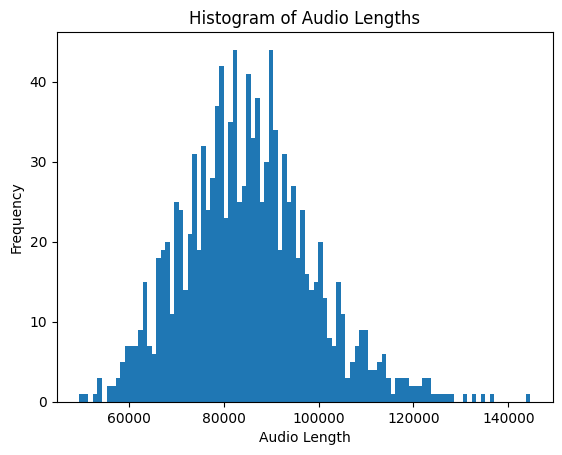

In [ ]:
# Plot the histogram of lenghts
plt.hist(lenghts, bins=100)
plt.xlabel('Audio Length')
plt.ylabel('Frequency')
plt.title('Histogram of Audio Lengths')
plt.show()

In [ ]:
LONGEST_LENGTH = 144648

## Aumento de dados

In [ ]:
!gdown 1FERZhKvNKcdpFGdEhSL7Uq3EcIU8k7Qd

Downloading...
From: https://drive.google.com/uc?id=1FERZhKvNKcdpFGdEhSL7Uq3EcIU8k7Qd
To: /content/bg_noises.zip
100% 3.45M/3.45M [00:00<00:00, 109MB/s]


In [ ]:
!unzip /content/bg_noises.zip

Archive:  /content/bg_noises.zip
  inflating: bg_noises/ruido_1.wav   
  inflating: bg_noises/ruido_2.wav   


In [ ]:
%%capture
!pip install librosa==0.9.0 audiomentations datasets torchinfo

In [ ]:
from scipy.io.wavfile import write
from audiomentations import TimeMask, PitchShift, TanhDistortion, AddBackgroundNoise, SpecFrequencyMask
import librosa

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from scipy.io.wavfile import write
from tqdm import tqdm

def data_aug(dataset, aug_function):
    new_file_names = []
    new_labels = []
    transcriptions = []

    for index, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
        file_path = os.path.join(row['path'])
        audio, sr = librosa.load(file_path, sr=None)
        noise_folder = os.path.dirname(file_path)

        augmented_audio, name = aug_function(audio, sample_rate=sr)

        new_file_name = f"{os.path.dirname(file_path)}/{name}_{index}_aug.wav"

        if not os.path.exists(new_file_name):
            new_file_names.append(new_file_name)
            new_labels.append(row['class'])
            transcriptions.append(row['transcription'])

            write(os.path.join(new_file_name), sr, (augmented_audio * 32767).astype(np.int16))

    aug_data = pd.DataFrame()
    aug_data['path'] = new_file_names
    aug_data['class'] = new_labels
    aug_data['transcriptions'] = transcriptions

    return aug_data


In [ ]:
def augment_audio_with_background_noise(audio, sample_rate, noise_folder = '/content/bg_noises'):
    name = 'background_noise'
    background_noise_files = os.listdir(noise_folder)
    noise_file = os.path.join(noise_folder, np.random.choice(background_noise_files))
    noise_audio, _ = librosa.load(noise_file, sr=sample_rate)
    background_noise_aug = AddBackgroundNoise(sounds_path=noise_folder, p=1.0)
    augmented_audio = background_noise_aug(audio, sample_rate=sample_rate)
    return augmented_audio, name

def augment_audio_with_tanh_distortion(audio, sample_rate):
    name = 'tanh_distortion'
    tanh_dist_aug = TanhDistortion(p=1.0)
    augmented_audio = tanh_dist_aug(audio, sample_rate=sample_rate)
    return augmented_audio, name

def augment_audio_with_spec_frequency_mask(audio, sample_rate):
    name = 'spec_frequency_mask'
    spec_aug = SpecFrequencyMask()
    augmented_audio = spec_aug(audio)
    return augmented_audio, name

def augment_audio_with_pitch_shift(audio, sample_rate):
    name = 'pitch_shift'
    pitch_shift_aug = PitchShift(p=1.0)
    augmented_audio = pitch_shift_aug(audio, sample_rate=sample_rate)
    return augmented_audio, name

def augment_audio_with_time_mask(audio, sample_rate):
    name = 'time_mask'
    time_mask_aug = TimeMask(min_band_part=0.1, max_band_part=0.15, fade=True, p=1.0)
    augmented_audio = time_mask_aug(audio, sample_rate=sample_rate)
    return augmented_audio, name

In [ ]:
aug1_data = data_aug(cleaned_df, augment_audio_with_background_noise)
aug2_data = data_aug(cleaned_df, augment_audio_with_tanh_distortion)
# aug3_data = data_aug(cleaned_df, augment_audio_with_spec_frequency_mask) -> Esse tá dando problema
aug4_data = data_aug(cleaned_df, augment_audio_with_pitch_shift)
aug5_data = data_aug(cleaned_df, augment_audio_with_time_mask)

100%|██████████| 1190/1190 [00:01<00:00, 744.79it/s]


In [ ]:
# Vou deixar a concatenação final em uma variável, ai vc pode decidir em qual delas armazenar
cleaned_aug_df = pd.concat([cleaned_df, aug1_data])
cleaned_aug_df = pd.concat([cleaned_df, aug2_data])
# cleaned_aug_df = pd.concat([cleaned_aug_df, aug3_data])
cleaned_aug_df = pd.concat([cleaned_aug_df, aug4_data])
cleaned_aug_df = pd.concat([cleaned_aug_df, aug5_data])

print("Número total de amostras após o aumento de dados:", len(cleaned_aug_df))

Número total de amostras após o aumento de dados: 4760


In [ ]:
cleaned_aug_df.drop('transcription', axis=1, inplace=True)

In [ ]:
cleaned_aug_df

,path,class
0,/content/Dados_wav/SUBIR/00000043-AUDIO-2024-0...,SUBIR
1,/content/Dados_wav/SUBIR/00000013-AUDIO-2024-0...,SUBIR
2,/content/Dados_wav/SUBIR/00000044-AUDIO-2024-0...,SUBIR
3,/content/Dados_wav/SUBIR/00000029-AUDIO-2024-0...,SUBIR
4,/content/Dados_wav/SUBIR/00000033-AUDIO-2024-0...,SUBIR
...,...,...
1185,/content/Dados_wav/TRAS/time_mask_1220_aug.wav,TRAS
1186,/content/Dados_wav/TRAS/time_mask_1221_aug.wav,TRAS
1187,/content/Dados_wav/TRAS/time_mask_1222_aug.wav,TRAS
1188,/content/Dados_wav/TRAS/time_mask_1223_aug.wav,TRAS


## Processamentozim

In [ ]:
# prompt: Split cleaned_aug_df into train and test. Make sure there are no augmentated data on the test dataset. Every augmented data has "aug.wav" ending. Include a portion of the not augmentated data on train as well

train_df = cleaned_aug_df[cleaned_aug_df['path'].str.contains("aug.wav")].sample(frac=0.8, random_state=24)
test_df = cleaned_aug_df[~cleaned_aug_df['path'].str.contains("aug.wav")]
train_df = pd.concat([train_df, cleaned_aug_df[~cleaned_aug_df['path'].str.contains("aug.wav")].sample(frac=0.2, random_state=24)])


# Model 1 Wav2Vec2

- Importar modelos

In [ ]:
# Initialize the processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-xlsr-53-portuguese")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-portuguese").to("cuda")


preprocessor_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53-portuguese were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53-portuguese and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You sho

In [ ]:
# Initialize the processor and model
processor = Wav2Vec2Processor.from_pretrained("/content/drive/MyDrive/BIA/7º Periodo/PAV/Trabalho Final/Modelos/Pipeline 1/asr_processor_augmented")
model = Wav2Vec2ForCTC.from_pretrained("/content/drive/MyDrive/BIA/7º Periodo/PAV/Trabalho Final/Modelos/Pipeline 1/asr_model_augmented").to("cuda")


## Functions

Esta função são responsáveis por processar os áudios e extrair as features necessárias.

In [ ]:
def pad_waveform(waveform, target_length):
    current_length = waveform.shape[1]
    if current_length < target_length:
        padding = target_length - current_length
        waveform = torch.nn.functional.pad(waveform, (0, padding), "constant", 0)
    return waveform

def extract_features(audio_file, target_length=LONGEST_LENGTH):  # Example target length: 10 seconds
    # Load audio file
    waveform, sample_rate = torchaudio.load(audio_file)

    # Pad waveform to ensure consistent length
    waveform = pad_waveform(waveform, target_length)

    # Process the waveform to match the model's expected input
    input_values = processor(waveform.squeeze().numpy(), sampling_rate=sample_rate, return_tensors="pt", padding=True).input_values

    return input_values

def collate_fn(batch):
    input_values = [item[0] for item in batch]
    labels = [item[1] for item in batch]


    # Pad input_values and labels
    input_values = torch.nn.utils.rnn.pad_sequence(input_values, batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=processor.tokenizer.pad_token_id)

    return input_values, labels



## Dataset/Dataloader

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset
import random

class FunctionCallingDataset(Dataset):
    def __init__(self, dataset, max_length=30000):
        self.dataset = dataset
        self.resampler = T.Resample(orig_freq=48000, new_freq=16000)
        self.label_map = {label: idx for idx, label in enumerate(dataset['class'].unique())}
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def pad_or_truncate(self, waveform):
        if waveform.shape[1] > self.max_length:
            waveform = waveform[:, :self.max_length]
        else:
            pad_length = self.max_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad_length))
        return waveform

    def load_and_process_audio(self, audio_path):
        waveform, sample_rate = torchaudio.load(audio_path)
        if sample_rate != 16000:
            waveform = self.resampler(waveform)
        waveform = self.pad_or_truncate(waveform)
        input_values = processor(waveform.squeeze().numpy(), sampling_rate=16000, return_tensors='pt').input_values
        return input_values,waveform

    def select_second_sample(self, idx, same_class):
        label1 = self.dataset.iloc[idx]['class']
        if same_class:
            candidates = self.dataset[self.dataset['class'] == label1].index.tolist()
        else:
            candidates = self.dataset[self.dataset['class'] != label1].index.tolist()

        if len(candidates) == 0:
            raise ValueError("No valid candidates found for the second sample selection")

        idx2 = random.choice(candidates)

        if idx2 >= len(self.dataset) or idx2 < 0:
            raise IndexError("Selected index for second sample is out-of-bounds")

        return idx2

    def __getitem__(self, idx):
        audio_path1 = self.dataset.iloc[idx]['path']
        input_values1,waveform1 = self.load_and_process_audio(audio_path1)

        same_class = random.choice([True, False])
        idx2 = self.select_second_sample(idx, same_class)

        audio_path2 = self.dataset.iloc[idx2]['path']
        input_values2,waveform2 = self.load_and_process_audio(audio_path2)

        return (input_values1, input_values2),torch.tensor(int(same_class), dtype=torch.float)
        #return (input_values1, input_values2), (waveform1,waveform2),torch.tensor(int(same_class), dtype=torch.float)


In [ ]:
# Create train and test dataset objects
train_dataset = FunctionCallingDataset(train_df)
test_dataset = FunctionCallingDataset(test_df)

# Create dataloader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
train_dataset[0][1][0].detach().cpu().numpy()[0]

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [ ]:
n = random.randint(0, len(train_dataset))
plt.plot(train_dataset[n][0][0].detach().cpu().numpy()[0])
plt.plot(train_dataset[n][1][0].detach().cpu().numpy()[0])

In [ ]:
waveform = train_dataset[n][1][0].detach().cpu().numpy()[0]


AttributeError: module 'torchaudio' has no attribute 'play'

## Networks

- Mini

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.conv1 = nn.Conv1d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5)

        self.fc1 = nn.Linear(39808, 128)  # Adjust the dimension based on your input size
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)

    def forward_once(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=4)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=4)
        x = F.relu(self.conv3(x))
        x = F.max_pool1d(x, kernel_size=6)
        x = x.view(x.size()[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


- small

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.conv1 = nn.Conv1d(1, 64, kernel_size=10)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=10)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=10)


        self.fc1 = nn.Linear(52736, 512)  # Adjust the dimension based on your input size
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 32)

    def forward_once(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=4)  # Increase pooling size
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=6)  # Increase pooling size
        x = F.relu(self.conv3(x))
        x = F.max_pool1d(x, kernel_size=6)  # Increase pooling size
        x = x.view(x.size()[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2



- base

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.conv1 = nn.Conv1d(1, 128, kernel_size=10)  # Increased the number of filters
        self.conv2 = nn.Conv1d(128, 256, kernel_size=10)  # Increased the number of filters
        self.conv3 = nn.Conv1d(256, 512, kernel_size=10)  # Increased the number of filters
        self.conv4 = nn.Conv1d(512, 1024, kernel_size=10)  # Added an additional convolutional layer

        self.fc1 = nn.Linear(32768, 1024)  # Adjust the dimension based on your input size
        self.fc2 = nn.Linear(1024, 512)  # Increased the number of neurons
        self.fc3 = nn.Linear(512, 256)  # Increased the number of neurons
        self.fc4 = nn.Linear(256, 32)  # Added an additional fully connected layer

    def forward_once(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=4)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=6)
        x = F.relu(self.conv3(x))
        x = F.max_pool1d(x, kernel_size=6)
        x = F.relu(self.conv4(x))
        x = F.max_pool1d(x, kernel_size=6)
        x = x.view(x.size()[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


## Loss

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


# Create an instance of the SiameseNetwork
model = SiameseNetwork()
print(model)
# Prepare a single input tensor (example input with batch size 1 and sequence length 200)
input_tensor = torch.randn(1, 1, 30000)  # Adjust dimensions according to your input shape

# Make a single inference
output = model.forward_once(input_tensor)

print(output)


SiameseNetwork(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=39808, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
)
tensor([[-0.0932, -0.0816, -0.1393,  0.0614,  0.0472, -0.1532, -0.0692, -0.0263,
          0.0770, -0.0248,  0.0138, -0.0009,  0.0775, -0.1773, -0.0028, -0.1195]],
       grad_fn=<AddmmBackward0>)


## Train script

In [ ]:
import torch
import torchaudio
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the training function
def train(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        for data in tqdm(train_loader):
            inputs, labels = data
            input1, input2 = inputs[0],inputs[1]
            input1, input2, labels = input1.to(device), input2.to(device), labels.to(device)

            optimizer.zero_grad()

            output1, output2 = model(input1, input2)
            loss = criterion(output1, output2, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Loss: {running_loss/len(train_loader)}")


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize dataset and dataloader
dataset = FunctionCallingDataset(train_df)  # Replace `your_dataset` with your actual dataset
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model, criterion and optimizer
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the model
num_epochs = 15
train(model, train_loader, criterion, optimizer, num_epochs)


Epoch [1/15]


100%|██████████| 97/97 [01:38<00:00,  1.02s/it]


Loss: 1.1492015498200643
Epoch [2/15]


100%|██████████| 97/97 [01:35<00:00,  1.02it/s]


Loss: 1.0965235190293223
Epoch [3/15]


100%|██████████| 97/97 [01:34<00:00,  1.03it/s]


Loss: 1.0906362011260593
Epoch [4/15]


100%|██████████| 97/97 [01:32<00:00,  1.05it/s]


Loss: 1.069711275936402
Epoch [5/15]


100%|██████████| 97/97 [01:34<00:00,  1.02it/s]


Loss: 1.0894818619354485
Epoch [6/15]


100%|██████████| 97/97 [01:36<00:00,  1.01it/s]


Loss: 1.0636499081690287
Epoch [7/15]


100%|██████████| 97/97 [01:35<00:00,  1.02it/s]


Loss: 1.0761084912978496
Epoch [8/15]


100%|██████████| 97/97 [01:35<00:00,  1.01it/s]


Loss: 1.0702867723002876
Epoch [9/15]


100%|██████████| 97/97 [01:39<00:00,  1.03s/it]


Loss: 1.0652780852366968
Epoch [10/15]


100%|██████████| 97/97 [01:35<00:00,  1.01it/s]


Loss: 1.055893010085391
Epoch [11/15]


100%|██████████| 97/97 [01:38<00:00,  1.01s/it]


Loss: 1.0538344131302588
Epoch [12/15]


100%|██████████| 97/97 [01:39<00:00,  1.03s/it]


Loss: 1.0517187800604044
Epoch [13/15]


100%|██████████| 97/97 [01:36<00:00,  1.00it/s]


Loss: 1.05898601738448
Epoch [14/15]


100%|██████████| 97/97 [01:35<00:00,  1.02it/s]


Loss: 1.0509210665201403
Epoch [15/15]


100%|██████████| 97/97 [01:39<00:00,  1.03s/it]

Loss: 1.0617759676323724


In [ ]:
import torch

# Assuming 'model' is your PyTorch model
torch.save(model.state_dict(), '/content/drive/MyDrive/BIA/7º Periodo/PAV/Trabalho Final/Modelos/Pipeline 3/pipeline3_m2_pipe1asr_mini.pth')


# Model 2 MFCC

## Dataloader

In [ ]:
import torch
from torch.utils.data import Dataset
import torchaudio
import torchaudio.transforms as T
import random

class FunctionCallingDataset(Dataset):
    def __init__(self, dataset, max_length=90000):
        self.dataset = dataset
        self.label_map = {label: idx for idx, label in enumerate(dataset['class'].unique())}
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def pad_or_truncate(self, waveform):
        if waveform.shape[1] > self.max_length:
            waveform = waveform[:, :self.max_length]
        else:
            pad_length = self.max_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad_length))
        return waveform

    def extract_mfcc(self, waveform, sample_rate=16000):
        mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=25, melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 25, 'center': False})
        mfcc = mfcc_transform(waveform)
        mfcc = (mfcc - mfcc.mean()) / mfcc.std()  # Normalize the MFCC
        return mfcc

    def get_sample(self, idx):
        audio_path = self.dataset.iloc[idx]['path']
        label = self.dataset.iloc[idx]['class']
        label_idx = self.label_map[label]

        waveform, sample_rate = torchaudio.load(audio_path)
        waveform = self.pad_or_truncate(waveform)
        mfcc = self.extract_mfcc(waveform, sample_rate)
        return mfcc, label_idx

    def __getitem__(self, idx):
        mfcc1, label1_idx = self.get_sample(idx)

        different_class = random.choice([True, False])

        candidates = self.dataset[self.dataset['class'] != label1_idx].index.tolist() if different_class else self.dataset[self.dataset['class'] == label1_idx].index.tolist()

        # Ensure there are valid candidates
        if len(candidates) <= 1:  # At least one other candidate is needed
            candidates = self.dataset.index.tolist()  # Use any other sample as a fallback

        #candidates.remove(idx)  # Remove the current index from candidates
        idx2 = random.choice(candidates)

        mfcc2, label2_idx = self.get_sample(idx2)

        return (mfcc1, mfcc2), torch.tensor(int(different_class), dtype=torch.float)


## Visualization

In [ ]:
train_dataset = FunctionCallingDataset(train_df)
test_dataset = FunctionCallingDataset(test_df)


In [ ]:
train_dataset[0][0][0].shape

torch.Size([1, 25, 561])

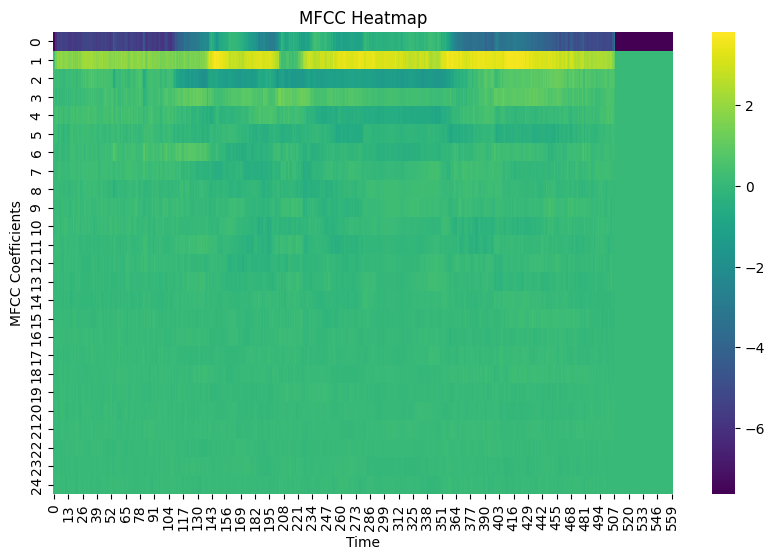

In [ ]:
# Plot an example MFCC
import seaborn as sns

def plot_mfcc_from_dataset(dataset, idx=0):
    (mfcc1, mfcc2), _ = dataset[idx]
    mfcc = mfcc1.squeeze().numpy()

    plt.figure(figsize=(10, 6))
    sns.heatmap(mfcc, cmap='viridis')
    plt.title("MFCC Heatmap")
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
    plt.show()

# Example usage
plot_mfcc_from_dataset(train_dataset, idx=0)


## Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3))

        self.fc1 = nn.Linear(34816, 512)  # Adjust the dimension based on your input size
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 32)

    def forward_once(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=(2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=(2, 2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=(1, 2))
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Create an instance of the SiameseNetwork
model = SiameseNetwork()

# Example input with batch size 1, 1 channel, 13 MFCC coefficients, and 98 time steps
input_tensor = torch.randn(32,1,25, 561)  # Adjust dimensions according to your input shape

# Make a single inference
output = model.forward_once(input_tensor)

print(output)


tensor([[-0.0596,  0.0227, -0.0115,  ...,  0.0352,  0.0265, -0.0572],
        [-0.0603,  0.0274, -0.0059,  ...,  0.0375,  0.0268, -0.0593],
        [-0.0564,  0.0251, -0.0129,  ...,  0.0336,  0.0313, -0.0657],
        ...,
        [-0.0603,  0.0208, -0.0045,  ...,  0.0267,  0.0291, -0.0598],
        [-0.0610,  0.0160, -0.0123,  ...,  0.0309,  0.0211, -0.0649],
        [-0.0571,  0.0243,  0.0002,  ...,  0.0309,  0.0240, -0.0654]],
       grad_fn=<AddmmBackward0>)


## Train

In [ ]:
import torch
import torchaudio
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the training function
def train(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        model.train()
        running_loss = 0.0

        for data in tqdm(train_loader):

            inputs, labels = data

            input1, input2 = inputs[0], inputs[1]
            input1, input2, labels = input1.to(device), input2.to(device), labels.to(device)

            output1, output2 = model(input1, input2)
            loss = criterion(output1, output2, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Loss: {running_loss/len(train_loader)}")


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize dataset and dataloader
dataset = FunctionCallingDataset(train_df)  # Replace `your_dataset` with your actual dataset
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model, criterion and optimizer
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 5
train(model, train_loader, criterion, optimizer, num_epochs)


Epoch [1/5]


100%|██████████| 97/97 [01:42<00:00,  1.05s/it]


Loss: 1.6675410129360317
Epoch [2/5]


100%|██████████| 97/97 [01:38<00:00,  1.01s/it]


Loss: 2.7182940859155558
Epoch [3/5]


100%|██████████| 97/97 [01:44<00:00,  1.08s/it]


Loss: 1.9789018385189097
Epoch [4/5]


 84%|████████▎ | 81/97 [01:27<00:17,  1.08s/it]


KeyboardInterrupt: 